## Exercise Set 3 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

### Exercise 1.

Using Numba, as discussed in [this lecture](https://lectures.quantecon.org/py/need_for_speed.html), write your own version of NumPy's [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) function, specializing in linear interpolation in one dimension.  

Note that NumPy's function is compiled native machine code and hence is fast.  But try to beat if you can, at least in some scenarios, by using Numba to speed up your code.  Show a time comparison between the two functions, for some suitable choice of test.

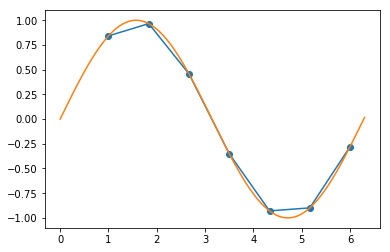

In [2]:
import timeit
from numba import jit

# I will assume the dimensions of the inputs xp, fp are the same, 
# and I will assume the all p in x are contained in the interval spanned by xp,
# i.e. I will only code the bare minimum for the sake of SPEED

# Function description outside, since I might lose time parsing it?


def myinterp(x, xp, fp):
    """
One-dimensional linear interpolation.

Returns the one-dimensional piecewise linear interpolant to a function
with given values at discrete data-points.

Parameters
----------
x : array_like
    The x-coordinates of the interpolated values.

xp : 1-D sequence of floats
    The x-coordinates of the data points, must be increasing if argument
    `period` is not specified. Otherwise, `xp` is internally sorted after
    normalizing the periodic boundaries with ``xp = xp % period``.

fp : 1-D sequence of floats
    The y-coordinates of the data points, same length as `xp`.

Returns
-------
y : float or ndarray
    The interpolated values, same shape as `x`.
"""
    k = 0
    lx = len(x)
    y = np.ones(lx)
    lf = len(fp)
    for j in range(0, lx):
        if x[j] > xp[lf-1]:
            y[j] = yp[lf-1]
        elif x[j] < xp[0]:
            y[j] = yp[0]
        else:
            for i in range(k, lf-2):
                if x[j] > xp[i] and x[j] < xp[i+1]:
                    y[j] = (yp[i]*(xp[i+1] - x[j]) + yp[i+1]*(x[j] - xp[i]))/(xp[i+1] - xp[i])
                    k = i # such that we don't have to parse from the start every time
    return y
    
# Without comments, since I might lose time parsing them?   
def myinterp(x, xp, fp):
    k = 0
    lx = len(x)
    y = np.ones(lx)
    lf = len(fp)
    for j in range(0, lx):
        if x[j] > xp[lf-1]:
            y[j] = fp[lf-1]
        elif x[j] < xp[0]:
            y[j] = fp[0]
        else:
            for i in range(k, lf-1):
                if x[j] >= xp[i] and x[j] <= xp[i+1]:
                    y[j] = (fp[i]*(xp[i+1] - x[j]) + fp[i + 1]*(x[j] - xp[i]))/(xp[i+1] - xp[i])
                    k = i 
    return y  


xs = np.concatenate( [np.linspace(0, 3, 100), np.linspace(3.1, 6.3, 100)])
ys = np.sin(xs)

x = np.linspace(1, 6, 7)
y = myinterp(x, xs, ys)


plt.scatter(x, y)
plt.plot(x, y )

#plt.scatter(xs, ys)
plt.plot(xs, ys)
plt.show()

jitinterp = jit(myinterp)

In [30]:
sim_length = 20

print("Numpy")
qe.util.tic()
y = np.interp(x, xs, ys)
qe.util.toc()

Numpy
TOC: Elapsed: 0.00033783912658691406 seconds.


0.00033783912658691406

In [38]:
print("My function")
qe.util.tic()
y = myinterp(x, xs, ys)
qe.util.toc()

My function
TOC: Elapsed: 0.00039386749267578125 seconds.


0.00039386749267578125

In [40]:
print("My function with numba")
qe.util.tic()
y = jitinterp(x, xs, ys)
qe.util.toc()

My function with numba
TOC: Elapsed: 0.0001590251922607422 seconds.


0.0001590251922607422

Even my bare-bone non-jit function can almost keep up, and its enhanced version beats numpy's interp.

### Exercise 2

Using your "Numbafied" linear interpolation function, try to use Numba to additionally speed up the endogenous grid method code from [this lecture](https://lectures.quantecon.org/py/egm_policy_iter.html).  Use CRRA utility and Cobb-Douglas production, as in that lecture, with the following parameter values.


Note: I didn't get much speed up.  I think because the outer loops don't matter much for speed, and hence it doesn't gain us much when we compile them.  

See how you go.

In [6]:
# From the lecture, we have:
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg


In [7]:

# Using my jitinterp function
def jitcoleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: jitinterp(x, y, c)
    return Kg



In [8]:
# Again, we follow the lecture:


## Define the model

alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

## Let's make convenience functions based around these primitives

# We don't need the coleman op
# def crra_coleman(g):
   # return coleman_operator(g, k_grid, beta, u_prime, f, f_prime, shocks)
# Only the end grid method code:

def crra_coleman_egm(g):
    return coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)

# in the numba version:
def jitcrra_coleman_egm(g):
    return jitcoleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)

In [9]:
sim_length = 20

print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g)
    g = new_g
qe.util.toc()

print("Timing policy function iteration with endogenous grid and Numba")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = jitcrra_coleman_egm(g)
    g = new_g
qe.util.toc()

Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.25591611862182617 seconds.
Timing policy function iteration with endogenous grid and Numba
TOC: Elapsed: 0.44245409965515137 seconds.


0.44245409965515137

The numba version oddly seems to be slower. I'll tweak some other functions wiht numba.


In [10]:
jitf = jit(f)

jitfp = jit(f_prime)

jitu= jit(u)

jitup = jit(u_prime)

jitupi = jit(u_prime_inv)

# Not sure if the following has an effect:

jitjitcoleman_egm = jit(jitcoleman_egm)


k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))


# in the numba version:
def jitcrra_coleman_egm(g):
    return jitcoleman_egm(g, k_grid, beta, jitup, jitupi, jitf, jitfp, shocks)

In [11]:
sim_length = 20

print("Timing policy function iteration with endogenous grid")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g)
    g = new_g
qe.util.toc()

print("Timing policy function iteration with endogenous grid and numba")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = jitcrra_coleman_egm(g)
    g = new_g
qe.util.toc()

Timing policy function iteration with endogenous grid
TOC: Elapsed: 0.12019515037536621 seconds.
Timing policy function iteration with endogenous grid and numba
TOC: Elapsed: 0.48306918144226074 seconds.


0.48306918144226074

It seems to have gotten even slower. I even experimented with alternative initial grids, to no avail.